# Face to Face
### Calculating the distance between faces
How does face recognition work? This code is a companion to an article [TODO insert link] on how modern face recogniton works - go there for a description of where face vectors / face embeddings come from.

For the purposes of this notebook, a face embedding is a representation of a face that allows us to compute how different or similar it is to another face.  These embeddings are produced from a cropped photograph of a face by a specially trained neural network. You can think of a vector as being the position of a face in some abstract "space of faces" where similar faces are near each other, and dissimilar faces are further apart.

We'll work with some vectors that we produced earlier and saved to a JSON file.  Want to make your own face vectors? [Use this handy script I wrote](https://github.com/EdwardDixon/facenet/tree/master/util) in my fork of [David Sanberg's excellent repo.](https://github.com/davidsandberg/facenet/)

As you read, I hope to show you that working with machine learning actually makes a software engineer's life _easier_, allowing us to do really useful things with forms of data that historically were easy to store and retrieve, but very difficult to actually analyse in any meaningful way.

## The Data Set
We've got 3 sets of photographs:

- The author, varying pose, but keeping background, lighting, hair, clothing, and camera constant
- The author, varying background, clothing, lighting, and age (one teenage photo)
- Faces from the main article

![Author poses](img/ed_poses.jpg)
![Author traveling](img/ed_travelling.jpg)
![Faces from the article](img/faces_from_article.png)

## Loading the data

Next, we'll:

- Load the data
- Prepare a function we can use to calculate the distance between two faces

The function in the `compare` method should look vaguely familiar: it is the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) that you were introduced to in secondary school - the C in this diagram.  The only difference is that our code is written to work in any number of spatial dimenions.  Our face vectors happen to have 128 dimensions, but that number is somewhat arbitrary.

![Euclidean distance](http://resumbrae.com/ub/dms423/05/euclidean.png)

In [1]:
import json 
import numpy as np

def compare(x,y):
    dist = np.sqrt(np.sum(np.square(np.subtract(x, y))))
    return (dist)

face_vectors = json.load(open("all_face_vecs.json"))

## Comparing me to myself

Time to do some math!  Let's take the vectors of my face and compare each possible pairing to find the (i) most similar and (ii) dissimilar pairs.

Most dissimilar:


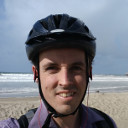

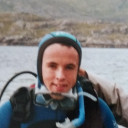

Most similar:


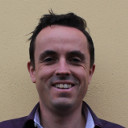

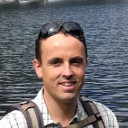

Average distance: 0.730963389668
Minimum distance: 0.372637673306
Maximum distance: 1.03945559118


In [2]:
import itertools
from IPython.display import Image
from IPython.display import display

eds = ['ed_looking_left.jpg',
 'ed_looking_ahead.jpg',
 'ed_in_sf.jpg',
 'ed_looking_right.jpg',
 'ed_profile.jpg',
 'ed_in_san_diego.jpg',
 'ed_in_connemara.jpg',
 'ed_in_cascades.jpg',
 'ed_in_dc.jpg']

# Here is where we generate a list of all possible pairings of images
pairs_of_eds = list(itertools.combinations(range(len(eds)), 2))
ed_scores = []
for p in pairs_of_eds:
    ed_scores.append(compare(face_vectors[eds[p[0]]], face_vectors[eds[p[1]]]))

ed_vecs = []
for k in eds:
    ed_vecs.append(face_vectors[k])
    
def print_summary_stats(scores):
    print("Average distance: " + str(np.average(scores)))
    print("Minimum distance: " + str(np.min(scores)))
    print("Maximum distance: " + str(np.max(scores)))
    return

def show_image_pair(a, b, height=128):
    a_image = Image(filename = "faces/"+ a, height=height)
    b_image = Image(filename = "faces/"+ b)
    display(a_image,b_image, height=height)    
    return

most_dissimilar = pairs_of_eds[np.argmax(ed_scores)]
most_similar = pairs_of_eds[np.argmin(ed_scores)]

print("Most dissimilar:")
show_image_pair(eds[most_dissimilar[0]], eds[most_dissimilar[1]])

print("Most similar:")
show_image_pair(eds[most_similar[0]], eds[most_similar[1]])

print_summary_stats(ed_scores)

There are some pretty interesting things about these pairings: notice that the "most similar" faces belong to pretty _dissimilar_ images; if we had been comparing only the original pixel values, then the photos of me against a yellow wall on an overcast day in Ireland would surely have been the most similar.  Instead, one image from that series has been matched with a picture taken high in the Cascades on a sunny day.  Comparisons like these can't tell us exactly what the neural network is paying attention to, but they help to show that it _is_ able to ignore a lot of irrelevant things.

### Important to know###
Part of getting a good-quality face vector is getting a nicely-cropped face image.  For example, the face vector for:
![Ed in front of lake](faces/ed_in_cascades.jpg) 
...is actually calculated using this sub-region ![Close-cropped face](faces/aligned/ed_in_cascades.png).  A user-friendly script to find and crop faces using a deep neural network [can be found here.](https://github.com/EdwardDixon/facenet/tree/master/src/align)

## A small enhancement

If we want to check identities and have multiple pictures with a known ground-truth, it makes sense to average the face vectors.  Think of a vector from a single one of these images as being a combination of some canonical "Ed's face" plus some irrelevant things (error and noise, and perhaps expression, pose, hair, etc. can still have an influence); then if we average multiple vectors, hopefully the "noise" component will cancel out.  Let's get an "average Ed" vector and check those distance stats again:

Average distance: 0.481337769104
Minimum distance: 0.304117871136
Maximum distance: 0.732085728809
Most average and most atypical Ed:


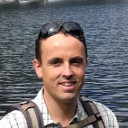

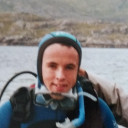

In [3]:
ed_vecs = np.asarray(ed_vecs)
ed_average_vec = np.average(ed_vecs, 0)

ed_scores_vs_average = []
for k in eds:
    ed_scores_vs_average.append(compare(face_vectors[k], ed_average_vec))

print_summary_stats(ed_scores_vs_average)

print ("Most average and most atypical Ed:")
closest_to_canonical = eds[np.argmin(ed_scores_vs_average)]
furthest_from_canonical = eds[np.argmax(ed_scores_vs_average)]

show_image_pair(closest_to_canonical, furthest_from_canonical)

Sure enough, my teenage self is relatively distant in appearence.


## What about identity?

Since our vectors are in a rather abstract "space of faces", we don't have familiar units like millimetres or inches to give us a sense of how large or small these numbers are: what does it actually _mean_ for two faces to be 0.73 units apart?

To give ourselves a better frame of reference, let's calculate the distance between my face and the other faces in the article.

In [4]:
not_ed = ['woman_with_curly_hair.jpg',
 'sunglasses_man.jpg',
 'mustache_man.jpg',
 'little_girl.jpg',
 'beard_in_profile.jpg',
 'lady_in_profile.jpg',
 'man_with_hat.jpg',
 'boy_with_glasses.jpg',
 'lady_with_bangs.jpg']

not_ed_vs_ed = []
for k in not_ed:
    not_ed_vs_ed.append(compare(face_vectors[k], ed_average_vec))
    
print_summary_stats(not_ed_vs_ed)

Average distance: 1.38569435733
Minimum distance: 1.2773327133
Maximum distance: 1.50513683471


Interesting!  Note that even the closest person was twice as far from "average Ed" as my most dissimilar photo (teen self in scuba gear).  Also note that all these people are at quite similar distances from me - less that 0.22 units between the closest and furthest.  With such large distances, it is clear I don't have any doppelgangers in the set - but, just for fun, let's see the closest and furthest!

Most like Ed, most unlike Ed:


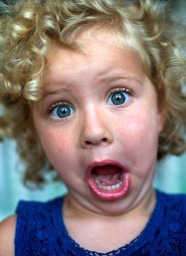

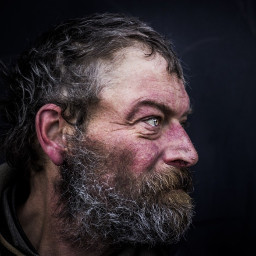

In [5]:
print ("Most like Ed, most unlike Ed:")
closest_to_ed = not_ed[np.argmin(not_ed_vs_ed)]
furthest_from_ed = not_ed[np.argmax(not_ed_vs_ed)]
show_image_pair(closest_to_ed, furthest_from_ed)

## A trip to (Face) Space

It would be really nice to plot our face vectors on a graph as a more visual way to illustrate distances.  However, our vectors have 128 spatial dimensions, which is 126 more than my laptop supports.  Luckily, a great algorithm called t-SNE lets us approximate their hyperspatial glory in something a little easier to see.  We'll be using low values of perplexity, which tends to preserve local geometry (values closer to 50 should preserve global differences at the expense of local ones - [read more in this excellent article.](https://distill.pub/2016/misread-tsne/). Thanks to the [really excellent Luuk Dersen](https://medium.com/@luckylwk) for providing really excellent sample code.

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

not_ed_vecs = []
for k in not_ed:
    not_ed_vecs.append(face_vectors[k])
    
X = np.concatenate([ed_vecs, not_ed_vecs], axis=0)
feat_col_names = [ 'x'+str(i) for i in range(X.shape[1]) ]
Y = eds.copy()
Y.extend(not_ed)
is_ed = np.concatenate([np.ones(len(eds)), np.zeros(len(not_ed))])

df = pd.DataFrame(X,columns=feat_col_names)
df['image'] = Y
df['is_ed'] = list(map( lambda x: str(x), is_ed))

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=200)
tsne_results = tsne.fit_transform(df[feat_col_names].values)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.215288
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.118376
[t-SNE] Error after 150 iterations: 1.118376


Now that our data is 2D, we can plot it on our screen and try to get some understanding of the structure in our data.

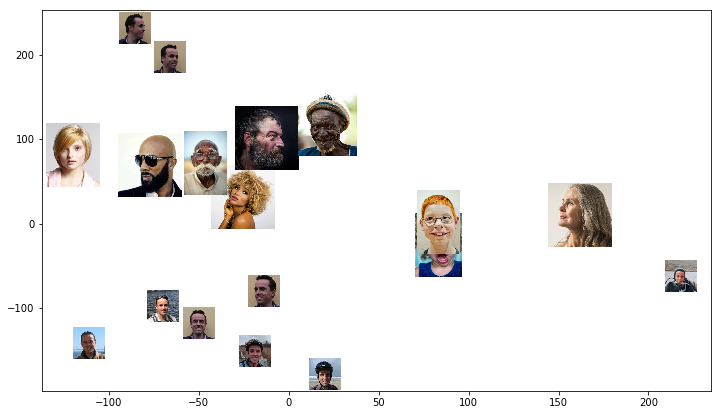

In [65]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scatter_faces(df_faces, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()

    x = df_faces['x-tsne']
    y = df_faces['y-tsne']
    x, y = np.atleast_1d(x, y)
    
    artists = []
    
    for i in range(0, df_tsne.shape[0]):
        try:
            image = plt.imread('faces/' + df_faces.iloc[i]['image'])
        except TypeError:
            # Likely already an array...
            pass
        im = OffsetImage(image, zoom=zoom)        
        ab = AnnotationBbox(im, (x[i], y[i]), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

fig, ax = plt.subplots(figsize=(12,7))


scatter_faces(df_tsne, ax=ax, zoom=0.25)


x = df_tsne['x-tsne']
y = df_tsne['y-tsne']
x, y = np.atleast_1d(x, y)

    
#ax.plot(x, y)
plt.show()
    


So, partly what we learn is that, with so few vectors, t-SNE struggles to neatly simplify the data.  However, it is still interesting to see the two kids land very close together, and to most pictures of the author near other pictures of the author.  Notice also that the four men who aren't me are clustered.

## Reviewing what we learned

- Deep neural networks can turn awkward sorts of data (like photos of faces) into a form (an "embedding") that is easier to work with
- Once we have an embedding, we can do lots of familiar operations, like measuring distance, sorting and plotting
- Working with machine-learning components doesn't have to be scary!